<a href="https://colab.research.google.com/github/lmcanavals/experiments/blob/main/Experimentos_y_significancia_estad%C3%ADstica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Experimentos y test de significancia

In [1]:
import random

import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats import power

import matplotlib.pylab as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
session_times = pd.read_csv("https://raw.githubusercontent.com/lmcanavals/experiments/main/data/web_page_data.csv")
session_times['Time'] = 100 * session_times['Time']
session_times.head()


,Page,Time
0,Page A,21.0
1,Page B,253.0
2,Page A,35.0
3,Page B,71.0
4,Page A,67.0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


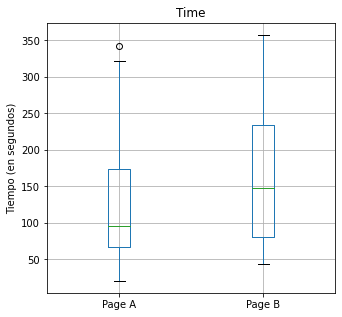

In [3]:
ax = session_times.boxplot(by='Page', column='Time', figsize=(5, 5))
ax.set_xlabel('')
ax.set_ylabel('Tiempo (en segundos)')
plt.suptitle('')

plt.show()

In [5]:
mean_a = session_times[session_times['Page'] == 'Page A']['Time'].mean()
mean_b = session_times[session_times['Page'] == 'Page B']['Time'].mean()
print(mean_b - mean_a)

35.66666666666667


In [7]:
def perm_fun(x, nA, nB):
  n = nA + nB
  idx_B = set(random.sample(range(n), nB))
  idx_A = set(range(n)) - idx_B
  return x.loc[idx_B].mean() - x.loc[idx_A].mean()

nA = session_times[session_times['Page'] == 'Page A'].shape[0]
nB = session_times[session_times['Page'] == 'Page B'].shape[0]
print(perm_fun(session_times['Time'], nA, nB))

-9.133333333333326


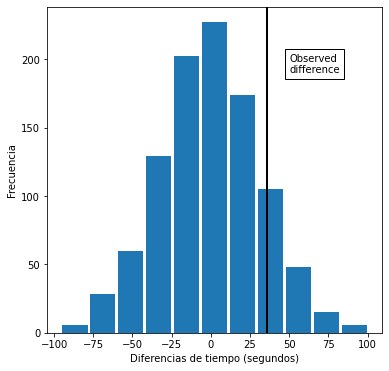

In [8]:
random.seed(1)
perm_diffs = [perm_fun(session_times['Time'], nA, nB) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color="black", lw=2)
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor': 'white'})
ax.set_xlabel('Diferencias de tiempo (segundos)')
ax.set_ylabel('Frecuencia')

plt.show()

# P-values

Diferencia observada: 0.0368


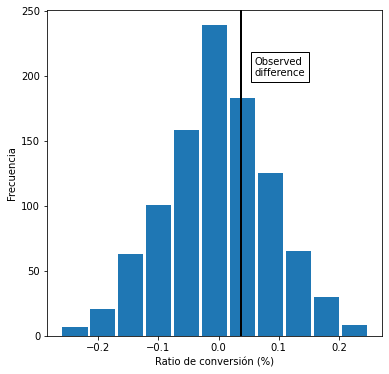

In [10]:
random.seed(1)
obs_pct_diff = 100 * (200 / 23739 - 182 / 22588)
print(f"Diferencia observada: {obs_pct_diff:.4f}%")
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

perm_diffs = [100 * perm_fun(conversion, 23739, 22588) for _ in range(1000)]

fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color="black", lw=2)
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor': 'white'})
ax.set_xlabel('Ratio de conversión (%)')
ax.set_ylabel('Frecuencia')

plt.show()

In [11]:
survivors = np.array([[200, 23539], [182, 22406]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f"p_value for single sided test: {p_value / 2:.4f}")

p_value for single sided test: 0.3498


# t-Tests

In [12]:
res = stats.ttest_ind(session_times[session_times['Page'] == 'Page A']['Time'],
                      session_times[session_times['Page'] == 'Page B']['Time'],
                      equal_var=False)
print(f"p-value for singe sided test: {res.pvalue / 2:.4f}")

p-value for singe sided test: 0.1408


# Anova

In [13]:
four_sessions = pd.read_csv('https://raw.githubusercontent.com/lmcanavals/experiments/main/data/four_sessions.csv')
four_sessions.head()

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172


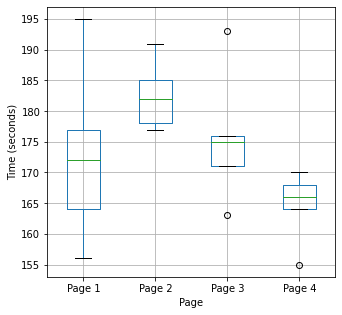

In [14]:
ax = four_sessions.boxplot(by="Page", column="Time", figsize=(5, 5))
ax.set_xlabel('Page')
ax.set_ylabel('Time (seconds)')
plt.suptitle("")
plt.title("")

plt.show()

In [16]:
observed_variance = four_sessions.groupby('Page').mean().var()[0]

print("Observed means:", four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655


In [17]:
def perm_test(df):
  df = df.copy()
  df['Time'] = np.random.permutation(df['Time'].values)
  return df.groupby('Page').mean().var()[0]

print(perm_test(four_sessions))

43.9066666666667


In [18]:
random.seed(1)
perm_variance = [perm_test(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in perm_variance]))

Pr(Prob) 0.08066666666666666


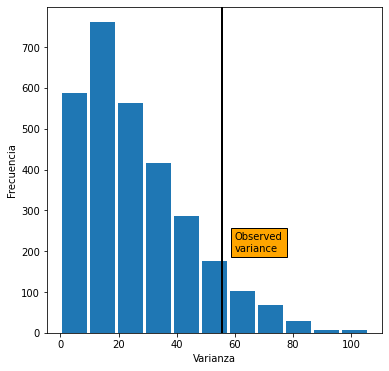

In [20]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.hist(perm_variance, bins=11, rwidth=0.9)
ax.axvline(x=observed_variance, color='black', lw=2)
ax.text(60, 200, 'Observed\nvariance', bbox={'facecolor': 'orange'})
ax.set_xlabel('Varianza')
ax.set_ylabel('Frecuencia')

plt.show()

# F-statistic

In [22]:
model = smf.ols('Time ~ Page', data=four_sessions).fit()
                
aov_table = sm.stats.anova_lm(model)
print(aov_table)

            df  sum_sq     mean_sq         F    PR(>F)
Page       3.0   831.4  277.133333  2.739825  0.077586
Residual  16.0  1618.4  101.150000       NaN       NaN
